# Project 4: EV Cars

## Part III - Modeling

Authors: Aichieh Lin, Bede Young, and Charles Ramey

Date: 05/05/2023

---

#### Notebook Links

Part I - Project Intro & Data Cleaning
- [`Part-1_setup-and-cleaning.ipynb`](../code/Part-1_setup-and-cleaning.ipynb)

Part II - Exploratory Data Analysis (EDA)
- [`Part-2_eda.ipynb`](../code/Part-2_eda.ipynb)

Part III - Modeling
- [`Part-3.1_modeling.ipynb`](../code/Part-3.1_modeling.ipynb)

Part IV - Conclusion, Recommendations, and Sources
- [`Part-4_conclusion-and-recommendations.ipynb`](../code/Part-4_conclusion-and-recommendations.ipynb)

### Contents

- [Data Import and Preprocessing](#Data-Import-and-Cleaning)
- [Modeling](#Modeling)

### Library Imports

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, BaggingRegressor
import scipy as scp


## Data Import and Preprocessing

### Data Import

In [181]:
elec = pd.read_csv('../output/charging-stations-population.csv', index_col='Unnamed: 0')
aq = pd.read_csv('../output/air_quality_by_state.csv')

### Preprocessing

In [182]:
# masks for year > 2010, since EV data is almost always 0 before this date
aq = aq[aq.year > 2010]
elec = elec[elec.year > 2010]

In [183]:
aq = aq.replace('Alaska', np.nan).dropna()
aq = aq.replace('Hawaii', np.nan).dropna()
aq = aq.replace('District Of Columbia', np.nan).dropna()
aq = aq.replace('Virgin Islands', np.nan).dropna()


In [184]:
aq.shape, elec.shape

((576, 18), (576, 12))

In [185]:
elec_2 = elec[['state', 'year', 'electric_by_pop']]

- dfs merged on state and year columns

In [186]:
df = aq.merge(elec_2, on=['state', 'year'])


In [187]:
elec_2.columns

Index(['state', 'year', 'electric_by_pop'], dtype='object')

In [188]:
obj = df[['state', 'year']]

In [189]:
ohe = OneHotEncoder(drop = 'first',
                    sparse = False,
                   handle_unknown='ignore')
obj = ohe.fit_transform(obj)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [190]:
obj = pd.DataFrame(obj, columns = ohe.get_feature_names_out())

In [191]:
to_drop = [
    'days_with_aqi',
    'pct_hazardous_days',
    'pct_very_unhealthy_days',
    'pct_unhealthy_days',
    'pct_unhealthy_for_sensitive_groups_days',
    'pct_moderate_days',
    '90th_percentile_aqi',
    'pct_good_days',
    'pct_days_pm10',
    'pct_days_pm2.5'
]

In [192]:
df.drop(columns = to_drop, inplace=True)

In [193]:
df_merged = pd.concat([obj,df], axis = 1)

In [194]:
df_merged

,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_Florida,state_Georgia,state_Idaho,state_Illinois,...,year_2022,state,year,max_aqi,median_aqi,pct_days_co,pct_days_no2,pct_days_ozone,pct_bad_days,electric_by_pop
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Alabama,2011,111.526316,42.789474,0.000288,0.000000,0.566842,0.304273,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Alabama,2012,110.235294,40.117647,0.000000,0.000000,0.597273,0.222823,0.008306
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Alabama,2013,86.055556,37.388889,0.000000,0.000152,0.608364,0.146973,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Alabama,2014,93.333333,38.166667,0.000000,0.001065,0.607310,0.170713,0.194143
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Alabama,2015,105.722222,39.333333,0.000000,0.001826,0.449222,0.221251,0.418354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Wyoming,2018,106.500000,39.611111,0.000000,0.007854,0.779945,0.210523,2.094872
572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Wyoming,2019,98.000000,38.833333,0.000000,0.004811,0.818655,0.128996,2.747257
573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Wyoming,2020,131.705882,34.882353,0.000000,0.061075,0.654444,0.123657,2.977814
574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Wyoming,2021,128.823529,36.294118,0.000323,0.061565,0.693599,0.216290,3.175244


---
## Modeling

In [195]:
X = df_merged.drop(columns = ['electric_by_pop', 'state', 'year'])
y = df_merged['electric_by_pop']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

### Baseline Model

In [196]:
base = [y_train.mean()]*len(y_train)

In [197]:
knn = KNeighborsRegressor()

knn.fit(X_train, y_train)
knn.score(X_train, y_train), knn.score(X_test, y_test)

(0.35236237103934187, -0.09030774359457916)

In [198]:
lr = LinearRegression()

lr.fit(X_train, y_train)
lr.score(X_train, y_train), knn.score(X_test, y_test)

(0.7876071750913761, -0.09030774359457916)

In [199]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [200]:
base_m = LinearRegression()
base_m.fit(X_train, base)

LinearRegression()

In [201]:
base_m.score(X_train_sc, y_train)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


0.0

In [202]:
base_m.score(X_test_sc, y_test)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


-0.0031470288908206356

- Baseline Model performs very badly, train and test R<sup>2</sup> scores of 0
- Basic models on unscaled data also perform very badly - R<sup>2</sup> test scores are much lower than training score, indicating overfitting and high variance

### K-Neighbors Regressor

In [203]:
knn = KNeighborsRegressor()

knn.fit(X_train_sc, y_train)
knn.score(X_train_sc, y_train), knn.score(X_test_sc, y_test)

(0.6323349909104468, 0.2895606692897539)

- knn model performs better than the null model, with R<sup>2</sup> test of 0.28, however the model is still very overfit and not performing very well nonetheless

In [204]:
gs_knn = GridSearchCV(
    knn,
    param_grid={
        'n_neighbors' : [2,3,5,7,9,11],
        'weights' : ['uniform'],
        'p' : [2,5,6]
    },
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

In [205]:
gs_knn.fit(X_train_sc, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 5, 7, 9, 11], 'p': [2, 5, 6],
                         'weights': ['uniform']},
             verbose=1)

In [206]:
gs_knn.best_estimator_

KNeighborsRegressor(n_neighbors=3)

In [207]:
gs_knn.best_estimator_.fit(X_train_sc, y_train)

KNeighborsRegressor(n_neighbors=3)

In [208]:
gs_knn.best_estimator_.score(X_train_sc, y_train)

0.696444681894485

In [209]:
gs_knn.best_estimator_.score(X_test_sc, y_test)

0.28037669335304016

#### Gridsearch KNN

- Following a gridsearch, KNN is performing better in terms of training score, but still is very poor in terms of variance and test R<sup>2</sup>

### Polynomial Features

In [210]:
poly = PolynomialFeatures(degree = 2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_sc)
X_test_poly = poly.transform(X_test_sc)

In [211]:
gs_knn.fit(X_train_poly, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 5, 7, 9, 11], 'p': [2, 5, 6],
                         'weights': ['uniform']},
             verbose=1)

In [212]:
gs_knn.best_estimator_

KNeighborsRegressor(n_neighbors=7)

In [213]:
gs_knn.best_estimator_.score(X_train_poly, y_train)

0.14595791979585782

In [214]:
gs_knn.best_estimator_.score(X_test_poly, y_test)

-0.10536006015930677

- Introducing polynomial features reduced the performance of the model in training and testing score

In [215]:
lr.fit(X_train_poly, y_train)

LinearRegression()

In [216]:
lr.score(X_train_poly, y_train)

1.0

In [217]:
lr.score(X_test_poly, y_test)

0.3106542918368529

- Linear regression polynomial features performed better in terms of training and test R<sup>2</sup>s, however the variance is very high and therefore this model is unusable

### Ridge

In [218]:
ridge = RidgeCV()

ridge.fit(X_train_sc, y_train)

RidgeCV()

In [219]:
ridge.score(X_train_sc, y_train)

0.7873806442419147

In [220]:
ridge.score(X_test_sc, y_test)

0.5790053524892496

- Ridge performs the best out of any model so far, with training R<sup>2</sup> of 0.78, and test R<sup>2</sup> of 0.57, this model outperforms the baseline model, but is still a low performance model and is very overfit

In [221]:
gs_ridge = GridSearchCV(
    RidgeCV(),
    param_grid={
        'alphas' : np.arange(0.1, 10, 0.1)
    },
    cv = 5, 
    verbose = 1,
    n_jobs= -1
)

In [222]:
gs_ridge.fit(X_train_sc, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5, estimator=RidgeCV(), n_jobs=-1,
             param_grid={'alphas': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             verbose=1)

In [223]:
gs_ridge.best_estimator_.score(X_train_sc, y_train), gs_ridge.best_estimator_.score(X_test_sc, y_test)

(0.7834625434050823, 0.5763860447592744)

### Random Forest Regressor

In [224]:
randf = RandomForestRegressor()

In [225]:
gs_randf = GridSearchCV(
    randf,
    param_grid={
        'n_estimators' : [80,90,100, 110,120],
        'max_depth' : [2,3,5,7],
        'min_samples_split' : [6,10, 15]
    },
    verbose = 1,
    cv = 4,
    n_jobs = -1
)

In [226]:
gs_randf.fit(X_train_sc, y_train)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 7],
                         'min_samples_split': [6, 10, 15],
                         'n_estimators': [80, 90, 100, 110, 120]},
             verbose=1)

In [227]:
gs_randf.best_estimator_

RandomForestRegressor(max_depth=7, min_samples_split=6, n_estimators=90)

In [228]:
gs_randf.best_estimator_.fit(X_train_sc, y_train)
gs_randf.best_estimator_.score(X_train_sc, y_train), gs_randf.best_estimator_.score(X_test_sc, y_test)

(0.8039140278913575, 0.43356420357521397)

- Random Forest R<sup>2</sup> training score is higher than ridge, but test scores are lower than ridge scores

### Bagging

In [229]:
bagging = BaggingRegressor(base_estimator=gs_randf.best_estimator_,n_estimators = 80)
bagging.fit(X_train_sc, y_train)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=7,
                                                      min_samples_split=6,
                                                      n_estimators=90),
                 n_estimators=80)

In [230]:
bagging.score(X_train_sc, y_train), bagging.score(X_test_sc, y_test)

(0.7102957522394353, 0.45525969694816426)

- bagging scores are lower than ridge, but outperform the random forest regressor, due to a slightly reduced variance

### Stacking

In [231]:
stack = StackingRegressor(
   [('bagging', bagging),
   ('gs_randf', gs_randf.best_estimator_)],
    final_estimator=gs_ridge
)

In [232]:
stack.fit(X_train_sc, y_train)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

Fitting 5 folds for each of 99 candidates, totalling 495 fits


StackingRegressor(estimators=[('bagging',
                               BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=7,
                                                                                     min_samples_split=6,
                                                                                     n_estimators=90),
                                                n_estimators=80)),
                              ('gs_randf',
                               RandomForestRegressor(max_depth=7,
                                                     min_samples_split=6,
                                                     n_estimators=90))],
                  final_estimator=GridSearchCV(cv=5, estimator=RidgeCV(),
                                               n_jobs=-1,
                                               param_grid={'alphas': array([0.1, 0.2, 0.3...
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
                                               verbose=1))

In [233]:
stack.score(X_train_sc, y_train)

0.7678056818455629

In [234]:
stack.score(X_test_sc, y_test)

0.46161130461531596

- Stacking scores are better than the baseline, but generally high variance and lower in test R<sup>2</sup> than Ridge

# Model Comparison

|Model_Name|Training_R<sup>2</sup>|Test_R<sup>2</sup>|
|---|---|---|
|BaseLine|0.000|-0.003|
|KNN|0.632|0.290|
|Grid_KNN|0.696|0.280|
|Poly_KNN|0.146|-0.105|
|Poly_Linear_Regression|1.000|0.310|
|Ridge|0.784|0.578|
|Random_Forest_Regressor|0.814|0.416|
|Bagging|0.706|0.452|
|Stack|0.759|0.472|

### Arizona Predictions

In [235]:
'''
Arizona masked dataframe preprocessed and set up for prediction generation
obj columns seperate and one hot encoded, prediction dataframe created with year and 
state column
'''


arizona = df[df.state == 'Arizona']
arizona_obj = arizona[['state', 'year']]
arizona_num = arizona.drop(columns = ['state', 'year', 'electric_by_pop'])

arizona_2 = arizona_obj


arizona_obj = arizona_obj.reset_index().drop(columns='index')
arizona_2 = arizona_2.reset_index().drop(columns='index')
arizona = arizona.reset_index().drop(columns='index')

arizona_obj.loc[12,:] = ['Arizona', 2023]
arizona_obj.loc[13,:] = ['Arizona', 2024]
arizona_obj.loc[14,:] = ['Arizona', 2025]
arizona_2.loc[12,:] = ['Arizona', 2023]
arizona_2.loc[13,:] = ['Arizona', 2024]
arizona_2.loc[14,:] = ['Arizona', 2025]


arizona_num = arizona_num.reset_index().drop(columns='index')

arizona_num.loc[12,:] = arizona_num.loc[11,:] * 0.9
arizona_num.loc[13,:] = arizona_num.loc[12,:] * 0.9
arizona_num.loc[14,:] = arizona_num.loc[13,:] * 0.9

arizona_2['pct_bad_days'] = arizona_num.pct_bad_days
arizona_2['electric_by_pop'] = arizona.electric_by_pop



In [236]:
arizona_obj = ohe.transform(arizona_obj)
arizona_obj = pd.DataFrame(arizona_obj, columns = obj.columns)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [237]:
arizona_test = pd.concat([arizona_obj, arizona_num], axis = 1)
# arizona_test = pd.DataFrame(ss.transform(arizona_test), columns = ss.get_feature_names_out())


In [238]:
pd.DataFrame(arizona_test.loc[12,:].array.reshape(1, -1), columns = arizona_test.columns)

,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_Florida,state_Georgia,state_Idaho,state_Illinois,...,year_2019,year_2020,year_2021,year_2022,max_aqi,median_aqi,pct_days_co,pct_days_no2,pct_days_ozone,pct_bad_days
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.992308,39.115385,0.0,0.0,0.538429,0.284505


In [239]:
arizona_2.loc[12,:] = ['Arizona', 2023, arizona_2.loc[11,'pct_bad_days'] * 0.9,
                       stack.predict(pd.DataFrame(arizona_test.loc[12,:].array.reshape(1, -1), 
                                                  columns = arizona_test.columns))]
arizona_2.loc[13,:] = ['Arizona', 2024,arizona_2.loc[12,'pct_bad_days'] * 0.9,
                       stack.predict(pd.DataFrame(arizona_test.loc[13,:].array.reshape(1, -1), 
                                                  columns = arizona_test.columns))]
arizona_2.loc[14,:] = ['Arizona', 2025, arizona_2.loc[13,'pct_bad_days'] * 0.9,
                       stack.predict(pd.DataFrame(arizona_test.loc[14,:].array.reshape(1, -1), 
                                                  columns = arizona_test.columns))]

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: Use

In [240]:
arizona_2

,state,year,pct_bad_days,electric_by_pop
0,Arizona,2011.0,0.316087,0.016995
1,Arizona,2012.0,0.372480,0.054920
2,Arizona,2013.0,0.333909,0.057291
3,Arizona,2014.0,0.318739,1.160404
4,Arizona,2015.0,0.249845,1.191857
5,Arizona,2016.0,0.269117,1.463751
6,Arizona,2017.0,0.353233,1.513343
7,Arizona,2018.0,0.303651,1.712763
8,Arizona,2019.0,0.262594,2.027830
9,Arizona,2020.0,0.289007,2.476343


- predictions using all models were unable to function as intended. The models fail to work on the new data, perhaps due to a lack of training on the years input.
- The data may also be not strong enough to generate a powerful regression model.
- Using a neural nework may improve this, however the dataset is so small that this likely would not be enough data to create a high performing neural network

In [241]:
stack.predict(X_test_sc)

array([0.69846998, 0.88299882, 2.52442483, 1.05298882, 0.76738853,
       4.65786079, 0.85945706, 2.75498067, 0.80030511, 1.36011351,
       2.83850193, 3.3294157 , 0.75939378, 0.81237577, 1.1405305 ,
       0.7915491 , 0.74644055, 3.68178164, 0.91594931, 1.23710363,
       2.47649661, 0.80180492, 0.80121732, 1.08869965, 3.26829844,
       0.82278052, 0.76183989, 3.79279106, 0.62765365, 0.95942557,
       0.79782951, 0.79864434, 6.86038053, 2.01437587, 0.82586385,
       0.73700127, 3.9310392 , 3.06201417, 0.76220701, 2.54092579,
       0.85773895, 2.13504526, 2.32943252, 0.82065303, 0.68028204,
       1.03023056, 0.79934134, 3.17595742, 0.76023328, 0.6355501 ,
       0.70764199, 1.20929135, 3.54095177, 8.32904978, 3.04943978,
       1.81329193, 1.99966522, 0.97557293, 0.75238793, 0.7055996 ,
       0.91575101, 0.81417032, 2.73462167, 0.6907142 , 3.25001149,
       4.01990265, 1.92738353, 0.74054681, 0.79452785, 0.73891639,
       0.98469541, 0.92692231, 2.31428627, 1.09516832, 1.27252

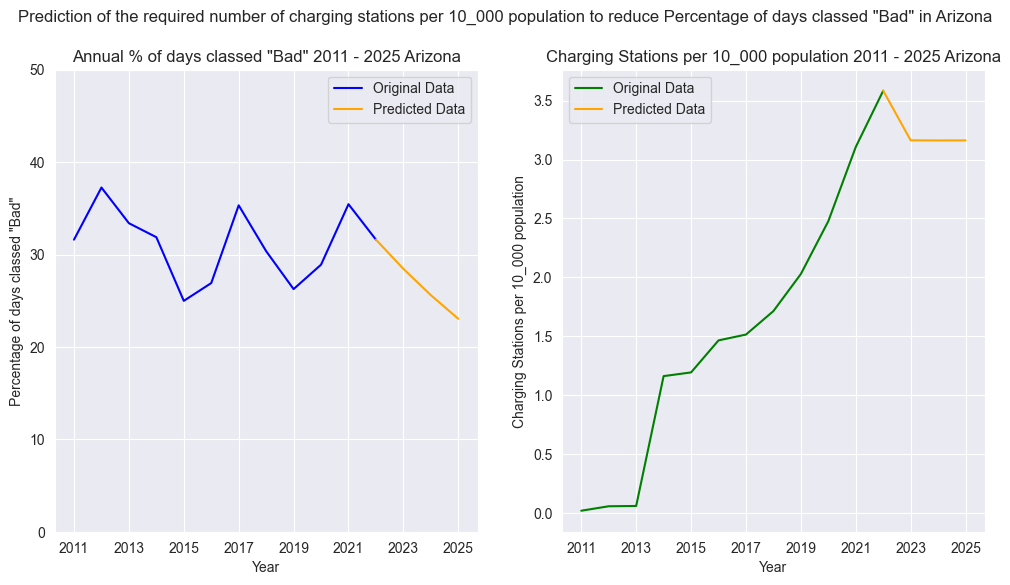

In [242]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

plt.suptitle('Prediction of the required number of charging stations per 10_000 population to reduce Percentage of days classed "Bad" in Arizona')

sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year < 2023].pct_bad_days * 100,
            ax = axs[0], color = 'b', label = 'Original Data')
sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year > 2021].pct_bad_days * 100,
            ax = axs[0], color = 'orange', label = 'Predicted Data')

axs[0].set_ylim(0,50)

axs[0].set_xticks([2011, 2013, 2015, 2017, 2019, 2021, 2023, 2025])
axs[0].set(title = 'Annual % of days classed "Bad" 2011 - 2025 Arizona', xlabel = 'Year', ylabel = 'Percentage of days classed "Bad"')
sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year < 2023].electric_by_pop,
            ax = axs[1], color = 'g', label = 'Original Data')
sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year > 2021].electric_by_pop,
            ax = axs[1], color = 'orange', label = 'Predicted Data')
axs[1].set(title = 'Charging Stations per 10_000 population 2011 - 2025 Arizona', xlabel = 'Year',
          ylabel = 'Charging Stations per 10_000 population')
axs[1].set_xticks([2011, 2013, 2015, 2017, 2019, 2021, 2023, 2025])

axs[0].legend();

- Left axis demonstrates the target improvements in the percent of days classed as 'bad'
- Right axis (theoretically) shows the required amount of charging stations that are needed to be installed to reach this goal

In [243]:
arizona_2.loc[12,:] = ['Arizona', 2023, arizona_2.loc[11,'pct_bad_days'] * 0.9,
                       arizona_2.loc[11, 'electric_by_pop'] * 1.1]
arizona_2.loc[13,:] = ['Arizona', 2024,arizona_2.loc[12,'pct_bad_days'] * 0.9,
                       arizona_2.loc[12, 'electric_by_pop'] * 1.1]
arizona_2.loc[14,:] = ['Arizona', 2025, arizona_2.loc[13,'pct_bad_days'] * 0.9,
                       arizona_2.loc[13, 'electric_by_pop'] * 1.1]

In [244]:
arizona_2

,state,year,pct_bad_days,electric_by_pop
0,Arizona,2011.0,0.316087,0.016995
1,Arizona,2012.0,0.372480,0.054920
2,Arizona,2013.0,0.333909,0.057291
3,Arizona,2014.0,0.318739,1.160404
4,Arizona,2015.0,0.249845,1.191857
5,Arizona,2016.0,0.269117,1.463751
6,Arizona,2017.0,0.353233,1.513343
7,Arizona,2018.0,0.303651,1.712763
8,Arizona,2019.0,0.262594,2.027830
9,Arizona,2020.0,0.289007,2.476343


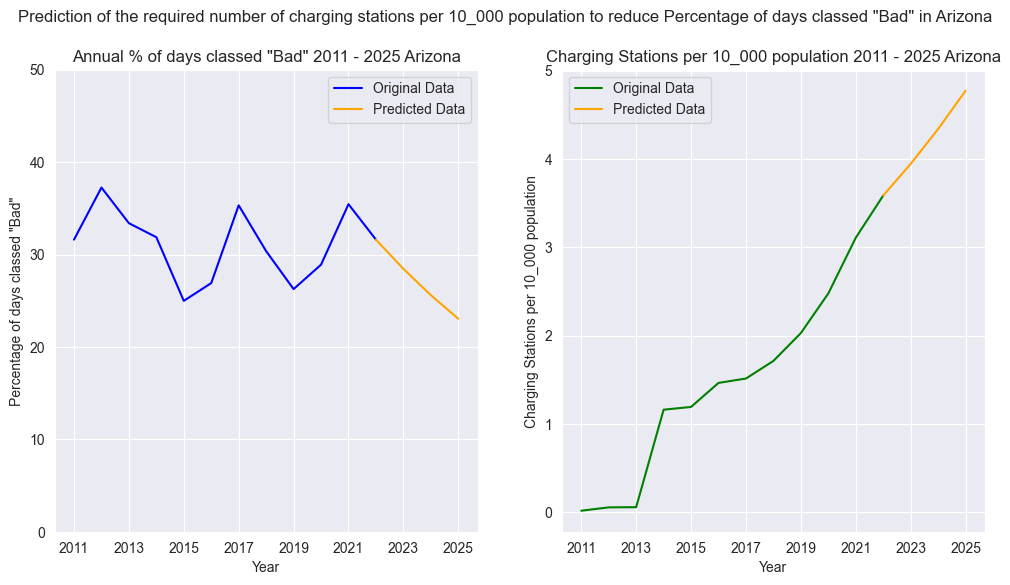

In [245]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

plt.suptitle('Prediction of the required number of charging stations per 10_000 population to reduce Percentage of days classed "Bad" in Arizona')

sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year < 2023].pct_bad_days * 100,
            ax = axs[0], color = 'b', label = 'Original Data')
sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year > 2021].pct_bad_days * 100,
            ax = axs[0], color = 'orange', label = 'Predicted Data')

axs[0].set_ylim(0,50)

axs[0].set_xticks([2011, 2013, 2015, 2017, 2019, 2021, 2023, 2025])
axs[0].set(title = 'Annual % of days classed "Bad" 2011 - 2025 Arizona', xlabel = 'Year', ylabel = 'Percentage of days classed "Bad"')
sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year < 2023].electric_by_pop,
            ax = axs[1], color = 'g', label = 'Original Data')
sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year > 2021].electric_by_pop,
            ax = axs[1], color = 'orange', label = 'Predicted Data')
axs[1].set(title = 'Charging Stations per 10_000 population 2011 - 2025 Arizona', xlabel = 'Year',
          ylabel = 'Charging Stations per 10_000 population')
axs[1].set_xticks([2011, 2013, 2015, 2017, 2019, 2021, 2023, 2025])

axs[0].legend();

In [246]:
pops = pd.read_csv('../output/charging-stations-population.csv')

In [247]:
pops.drop(columns = 'Unnamed: 0', inplace=True)

In [248]:
pops.head()

,state,year,population,biodiesel,cng,e85,electric,hydrogen,lng,propane,total,electric_by_pop
0,Alabama,2008,4718206.0,11.0,3.0,6.0,0.0,0.0,0.0,40.0,60.0,0.000000
1,Arizona,2008,6280362.0,10.0,40.0,23.0,5.0,1.0,5.0,51.0,135.0,0.007961
2,Arkansas,2008,2874554.0,2.0,3.0,7.0,0.0,0.0,0.0,37.0,49.0,0.000000
3,California,2008,36604337.0,36.0,184.0,13.0,376.0,26.0,28.0,199.0,862.0,0.102720
4,Colorado,2008,4889730.0,18.0,18.0,65.0,0.0,0.0,0.0,43.0,144.0,0.000000


In [249]:
pops = pops[pops.year > 2009]

In [250]:
pops[pops.state == 'Arizona']

,state,year,population,biodiesel,cng,e85,electric,hydrogen,lng,propane,total,electric_by_pop
97,Arizona,2010,6407172.0,14.0,36.0,32.0,8.0,1.0,5.0,61.0,157.0,0.012486
145,Arizona,2011,6472643.0,5.0,6.0,20.0,11.0,0.0,0.0,49.0,91.0,0.016995
193,Arizona,2012,6554978.0,4.0,5.0,33.0,36.0,0.0,0.0,44.0,122.0,0.054920
241,Arizona,2013,6632764.0,5.0,8.0,30.0,38.0,0.0,0.0,39.0,120.0,0.057291
289,Arizona,2014,6730413.0,78.0,36.0,30.0,781.0,1.0,7.0,66.0,999.0,1.160404
337,Arizona,2015,6829676.0,76.0,38.0,30.0,814.0,0.0,8.0,93.0,1059.0,1.191857
385,Arizona,2016,6941072.0,76.0,36.0,25.0,1016.0,0.0,8.0,93.0,1254.0,1.463751
433,Arizona,2017,7044008.0,76.0,30.0,21.0,1066.0,0.0,8.0,89.0,1290.0,1.513343
481,Arizona,2018,7158024.0,77.0,28.0,22.0,1226.0,0.0,8.0,86.0,1447.0,1.712763
529,Arizona,2019,7278717.0,78.0,30.0,22.0,1476.0,1.0,8.0,75.0,1690.0,2.027830


In [251]:
pops[pops.state == 'Arizona'].loc[673,'population'] / pops[pops.state == 'Arizona'].loc[625,'population']

1.012983014027629

In [252]:
(arizona_2.loc[12,'electric_by_pop'] * 
                                           ((pops.loc[712, 'population'] * 1.012) / 10_000))

11983.031541886323

In [254]:
arizona_2['charging_stations_required'] = 0

In [258]:
arizona_2['charging_stations_required'].loc[12] = int((arizona_2.loc[12,'electric_by_pop'] * 
                                           ((pops.loc[673, 'population'] * 1.012) / 10_000)))
arizona_2['charging_stations_required'].loc[13] = int((arizona_2.loc[13,'electric_by_pop'] * 
                                           ((pops.loc[673, 'population'] * (1.012**2)) / 10_000)))
arizona_2['charging_stations_required'].loc[14] = int((arizona_2.loc[14,'electric_by_pop'] * 
                                           ((pops.loc[673, 'population'] * (1.012**3)) / 10_000)))

In [259]:
for i in range(12):
    arizona_2.loc[i,'charging_stations_required'] = pops[pops.state == 'Arizona'].reset_index().loc[i, 'electric']

In [260]:
arizona_2

,state,year,pct_bad_days,electric_by_pop,charging_stations_required
0,Arizona,2011.0,0.316087,0.016995,8.0
1,Arizona,2012.0,0.372480,0.054920,11.0
2,Arizona,2013.0,0.333909,0.057291,36.0
3,Arizona,2014.0,0.318739,1.160404,38.0
4,Arizona,2015.0,0.249845,1.191857,781.0
5,Arizona,2016.0,0.269117,1.463751,814.0
6,Arizona,2017.0,0.353233,1.513343,1016.0
7,Arizona,2018.0,0.303651,1.712763,1066.0
8,Arizona,2019.0,0.262594,2.027830,1226.0
9,Arizona,2020.0,0.289007,2.476343,1476.0


- Using this theoretical prediction, we can state that to meet the 10% per year reduction in days classed 'bad' for air pollution, the number of charging stations that would need to be installed in Arizona would be:
    - 2023 : 2936,
    - 2024 : 3269,
    - 2025 : 3639
    
- current numbers in Arizona are 2257, from data collected in 2022

### Conclusion and Recommendations

Through our analysis, we observed a direct relationship between the number of available EV charging stations and the number of EVs owned. This is consistent with consumer surveys that identify lack EV charging stations as a key reason consumers are choosing not to switch to an EV. Our exploration of the data also revealed a correlation between the number of EV charging stations and the AQI for a number of states, though the evidence is not overwhelming.

The models created in this project do not conclusively suggest that an increase in the number of EV charging stations and EVs will yield the desired reduction in poor air quality days. However, the findings of our EDA lead us to believe that it is worth continuing to investigate this relationship as well as other factors that influence EV ownership. 

Theoretical predictions showed that with a stronger model, we were able to generate predicted targets for EV charging station installments in Arizona - based on 10% annual reductions in the number of days classed 'bad' for air quality.

Our recommendations for advancement of this analysis and next steps include:
- Evaluating Alternative Data Sources:
    - This analysis used daily and annual AQI data, however one shortcoming of this data is that its availability by county, state, and year varies. In some cases, AQI data is collected nearly every day of the year and in others it is collected far less. As a result, a lot of detail was lost through the normalization of the data.
    - Using actual concentrations of emissions-specific pollutants would likely yield better results, as AQI is a measurement of overall air quality and can be influenced heavily by unrelated events like wildfires.
- Improving the Models:
    - While model performance is heavily impacted by the data used, time constraints hindered the optimization of modeling efforts. Additional time and care should be taken to refine and improve both time-series and regression models.
- Investigating Other Factors:
    - Many consumers cited insufficient charging station availability as a reason why they would not purchase an EV, though other major factors include: high cost, battery range (miles), time to charge, and a general preference for gasoline vehicles.

---